## C++ implementation
The C++ implementation is rather straitforward rewriting of python stochastic procedures. You can find source files in cpp folder. It was compiled by MS VisualStudio 2017 and uses some C++17 features. Compiled executable stochastic.exe is for 64bit Windows OS. For other OS you can compile the files yourself on any appropriate C++ compiler supporting C++17 standard. To pass parameters to the application configuration file config.txt is used. Results are written in dynamics.txt and tests.txt files. The application (stochastic.exe) gets directory for config.txt,dynamics.txt, and tests.txt files as command string parameter -d. So python interface for stochastic.exe is following:

In [1]:
import matplotlib.pyplot as plt
import os
import time

# to not repeat HCS_SIR and HCS_SIR2 implementation we place it into separate file
from hcs_sir import * 


def exec_SIR(r0_0,I0,τ,vs0,vb0,T=12.0,
             vcb=0.4,nlp=0.5,tp=0.25,elr=0.0,ps=80000,
             sn=50,mtl=100,seed=317,exec_type=0,
             s_rate=0,dir='c:\\tmp'):
    command=f'stochastic.exe -d"{dir}"'
    with open(dir+"\\config.txt", "rt") as file:
        conf=dict(np.loadtxt(file,dtype=('U32,f8')))
    conf["final_time"]=T
    conf["simulations_number"]=sn
    conf["min_trace_len"]=mtl
    conf["resample_step"]=t_step
    conf["population_size"]=ps
    conf["initial_R0"]=r0_0
    conf["variance_of_social_activity"]=vs0
    conf["variance_of_catchability"]=vb0
    conf["variance_of_spreadability"]=vcb
    conf["inverse_tau"]=1.0/τ
    conf["new_lineage_prob"]=nlp
    conf["test_prob"]=tp
    conf["external_lineages_rate"]=elr
    #if seed is 0 it automatically randomized
    conf["initial_seed"]=seed
    
    #exec_type
    #0 - SIR dynamics (correspond to HCS_SIR2) & lineage distribution 
    #1 - SIR dynamics (correspond to HCS_SIR)
    #2 - SIR dynamics (correspond to HCS_SIR) another method
    #3 - SIRS dynamics (correspond to HCS_SIR2)
    conf["exec_type"]=exec_type
    conf["s_rate"]=s_rate
    
    with open(dir+"\\config.txt", "wt") as file:
        for k in conf:
            file.write(f'{k} {conf[k]}\n')
    time.sleep(1)        
    return os.system(command)


To get dynamics we need a procedure to read it from the file and we can compare it with HCS_SIR model. The procedure reads the results  from dynamics.txt file. The file contains four columns:#trace, time, Suscectible number, Infectious number. The procedure splits results by trace number. For each trace it normalizes the values to $[0,1]$ interval, throws the values below I0, throws traces shorter than m_l, and cuts the tails of the traces to make the lengths of the traces the same. 

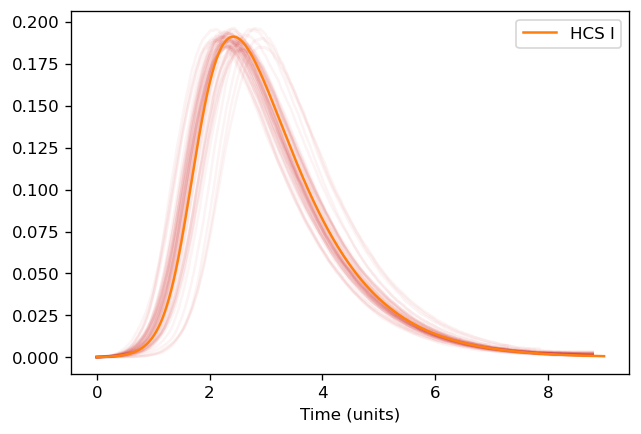

In [2]:
def dynamics_from_file(I0,l_m=100,path="c:\\tmp"):
    with open(path+"\\dynamics.txt", "rt") as file:
        trace_numb,T,S,I=np.loadtxt(file).T
    resT=[]    
    resS=[]    
    resI=[]
    l_min=100000000;
    TN=int(trace_numb[-1])+1
    for tn in range(TN):
        mask=(trace_numb==tn)
        t=T[mask]
        s=S[mask]
        i=I[mask]
        N=s[0]+i[0]
        s/=N
        i/=N
        pos=np.argmax(i>I0)
        t=t[pos:]
        s=s[pos:]
        i=i[pos:]
        l=len(t)
        if l>l_m:
            if(l<l_min):l_min=l
            resT.append(t-t[0])
            resS.append(s)
            resI.append(i)
    l_min-=1    
    for tn in range(len(resT)):
        resT[tn]=resT[tn][:l_min]
        resS[tn]=resS[tn][:l_min]
        resI[tn]=resI[tn][:l_min]
    return np.vstack(resT), np.vstack(resS),np.vstack(resI) 

vs0=0.7
vb0=0.2
r0_0=5.2
I0=0.0002
τ=0.4
exec_SIR(r0_0,I0,τ,vs0,vb0,exec_type=1)
T,S,I=dynamics_from_file(I0);
fig, ax = plt.subplots(dpi=120)
for t,i in zip(T,I):
    plt.plot(t, i,color='C3', alpha=0.05)
s,i=HCS_SIR(r0_0,I0,τ,vs0,vb0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
ax.set_xlabel(f'Time (units)')
plt.show()


It is interesting to draw the average of stochastic traces. As you can see the stochastic traces looks similarly but have different time lag. So to get correct average value we need to average rather time lags than the values.

In [3]:
def get_avr_trace(t,S,I):
    trace_numb,trace_len=I.shape
    cut_v=np.amax(I, axis=1).mean()/2
    shifts=np.argmax(I>cut_v, axis=1)
    shifts=int(shifts.mean())-shifts
    sum_I=np.zeros(trace_len)
    sum_S=np.zeros(trace_len)
    sum_n=np.zeros(trace_len)
    for tn in range(trace_numb):
        sh=shifts[tn]
        mask=np.ones(trace_len,dtype=np.bool)
        if(sh>=0):
            mask[:sh]=False
        else:
            mask[sh:]=False
        sum_I+=np.roll(I[tn],sh)*mask
        sum_S+=np.roll(S[tn],sh)*mask
        sum_n+=mask
    s,i=sum_S/sum_n,sum_I/sum_n
    l=min(len(t),trace_len)
    return t[:l],s[:l],i[:l]    


Now we can compare HCS_SIR and average of stochastic SIR and get pretty good match:

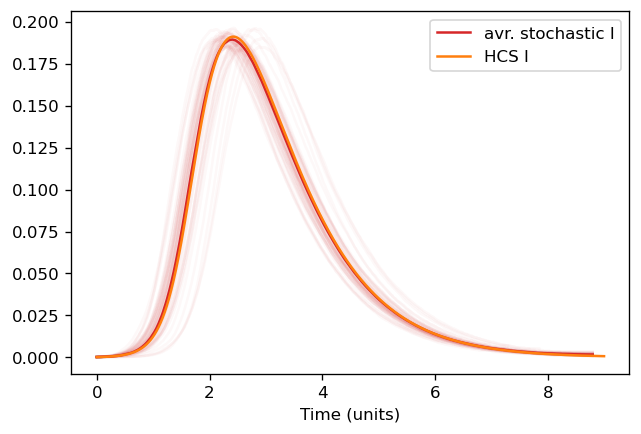

In [4]:
fig, ax = plt.subplots(dpi=120)
for t,i in zip(T,I):
    plt.plot(t, i,color='C3', alpha=0.03)
t,s,i=get_avr_trace(m_t,S,I)
plt.plot(t, i,color='C3', label=f'avr. stochastic I')    
s,i=HCS_SIR(r0_0,I0,τ,vs0,vb0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
ax.set_xlabel(f'Time (units)')
plt.show()

## Lineages' distribution

### Real data to compare

The real data for comparison we get from *du Plessis L, McCrone JT, Zarebski AE,Hill V, et al.: Establishment & lineage dynamics of the SARS-CoV-2 epidemic in the UK. medRxiv:2020.10.23.20218446 (2020).* https://science.sciencemag.org/content/371/6530/708. You can download the data yourself from https://science.sciencemag.org/content/suppl/2021/01/07/science.abf2946.DC1 by following link *Data S4* on the page.

Most interesting is the figure 2C.
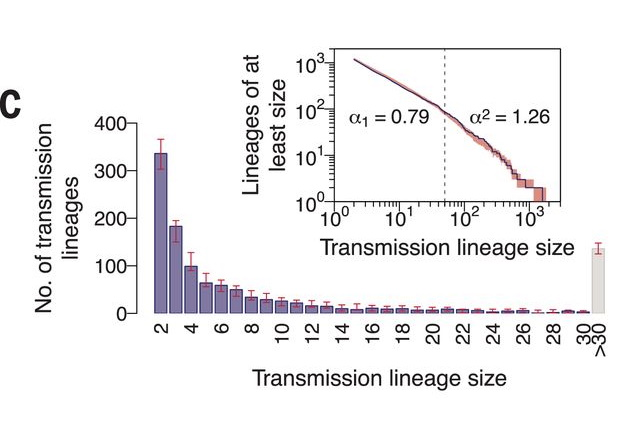

To process and draw the data we need several helper functions

In [5]:
def freq_from_tests(t_data,cut=0):
    _,l_data=np.unique(t_data, return_counts = True)
    return freq_from_lineages(l_data,cut=cut)
    
def freq_from_lineages(l_data,cut=0):
    l_data=l_data[l_data>cut]
    l_size,l_freq=np.unique(-l_data, return_counts = True)
    return np.flip(-l_size),np.flip(l_freq.cumsum())    
        
def draw_lineages_distr(func,lineages,k=30,min_len=10,cut=0):
    fig, ax = plt.subplots(dpi=120)
    plt.xscale('log')
    plt.yscale('log')
    t_avr=np.zeros(k)
    t_n=np.zeros(k)
    f_avr=np.zeros(k)
    f_n=np.zeros(k)
    for l_data in lineages:
        t,f=func(l_data,cut=cut)
        if(len(f)>min_len):
            mask=f<k
            ind=np.int_(f[mask])
            t_avr[ind]+=t[mask]
            t_n[ind]+=1
            mask=t<k
            ind=np.int_(t[mask])
            f_avr[ind]+=f[mask]
            f_n[ind]+=1
            plt.scatter(t,f,s=2.,color='C0',alpha=0.03)
    def coef(a,b):
        l=len(a)
        a_sum=a.sum()
        return ((a*b).sum()*len(a)-a_sum*b.sum())/((a**2).sum()*len(a)-a_sum**2)
    mask=f_n>0
    t,f=np.arange(k)[mask],f_avr[mask]/f_n[mask]
    print(f"gray points slope {-coef(np.log(t),np.log(f))}")
    plt.scatter(t,f,s=2.,color='gray')        
    mask=t_n>0
    t,f=t_avr[mask]/t_n[mask],np.arange(k)[mask]
    print(f"brown points slope {-coef(np.log(t),np.log(f))}")
    plt.scatter(t,f,s=2.,color='brown') 
    ax.set_xlabel(f'lineage size')
    ax.set_ylabel(f'lineages of at least size')
    plt.show()  


Now load and show the data from the article:

gray points slope 0.8309984285540272
brown points slope 1.2563932648784728


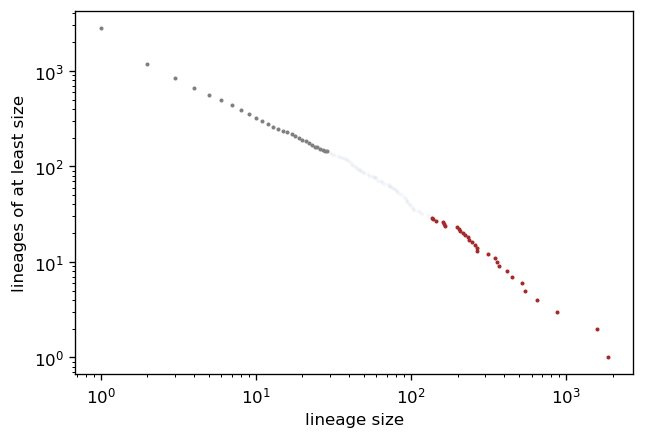

In [6]:
lin_name,lin_size,f_date,l_date=np.loadtxt('abf2946-Data-S4.csv',
                                delimiter=",",dtype='U24',skiprows=1,usecols=(0,1,4,5))[:-1].T
draw_lineages_distr(freq_from_lineages,[lin_size.astype('f8'),])

The function draw_lineages_distr intended to draw multiple stochastic traces. It calculates mean over the traces for k (by default k=35) points with the smallest lineages number (gray points) and for k points with the largest lineages number (brown points). It is only one trace of real data, so mean is trivial. The function also prints out the slope of the "head" (gray points,  $\alpha_1$ in the article) and the slope of "tail" (brown points,  $\alpha_2$ in the article). So, basically the figure above reproduces figure 2C from the article. Also, on the figure above we can see small S-like curving of the graphic.

### Stochastic modelling
The stochastic SIR model described previously was augmented with lineages generating and tracing, also mass testing (sequencing) simulation. As for the latter, it controls by test_prob parameter. The parameter defines the probability to perform sequencing on infection event. A patient testing first of all performed right after first signs of illness appears. So, this model of testing (fix testing probability at infection event) is not so far from real life.  

Parameter controlling lineages generating is new_lineage_prob - $\theta$. The parameter describes probability $dp$ of emerging new lineage in infinitesimal $dt$ time:
$$dp=\theta I dt$$
where $I$ is the number of infectios persons.

Assuming constant $I$, for a finite time interval $\Delta t$ the probability $\Delta p$ of at least one new lineage is:
$$\Delta p=1-\exp(-\theta I \Delta t)$$

On successful infection spread event (with a delay of $\Delta t$ after previous one) our implementation randomly selects existing lineage with a probability proportional to its spreadability (the sum of spreadabilities of the persons infected by the lineage). The lineage selected becomes spreading lineage with probability $1-\Delta p$, otherwise (with probability $\Delta p$) it creates a descendant lineage which becomes spreading. Finally, spreading lineage infects the person selected for the spread event.    

The application (stochastic.exe) place the tests results in the file tests.txt. The file has following format: #trace, time of a test, #lineage found by the test. The procedure below extracts data from the file.

In [7]:
def tests_from_file(path="c:\\tmp"):
    with open(path+"\\tests.txt", "rt") as file:
        trace_numb,T,L=np.loadtxt(file).T
    resT=[]    
    resL=[]    
    TN=int(trace_numb[-1])+1
    for tn in range(TN):
        mask=(trace_numb==tn)
        resT.append(T[mask])
        resL.append(L[mask])
    return resL,resT 

gray points slope 1.2476828017413413
brown points slope 0.6195897902013364


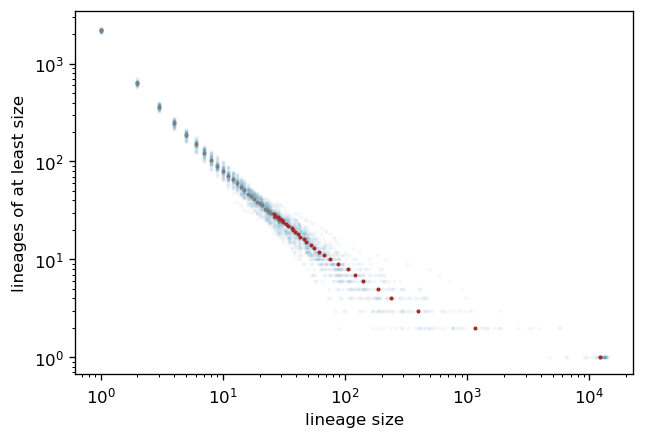

In [8]:
vs0=0.5
vb0=0.4
r0_0=5.2
I0=0.0002
τ=0.4
θ=0.2
test_prob=0.25
exec_SIR(r0_0,I0,τ,vs0,vb0,nlp=θ,ps=150000, tp=test_prob,exec_type=0)
resL,_=tests_from_file()
draw_lineages_distr(freq_from_tests,resL)

The whole picture look very different from real one. Gray points have bigger slope than brown ones. Look at the rightmost point. This point is corresponded to the largest (initial) lineage. The problem is the largest lineage is too large. It was alone for a quite a while from the beginning of the simulation and had no concurrent. That's why it is so large. To fix the situation we need more lineages from the very beginning. So, we need external lineages' inflow. 

We incorporate external lineages' inflow in the modelling procedure. It controlled by parameter external_lineages_rate showing how many external lineages' inflow in a unit of time. Let's try ones again:

gray points slope 0.9115158843888368
brown points slope 1.191724859814817


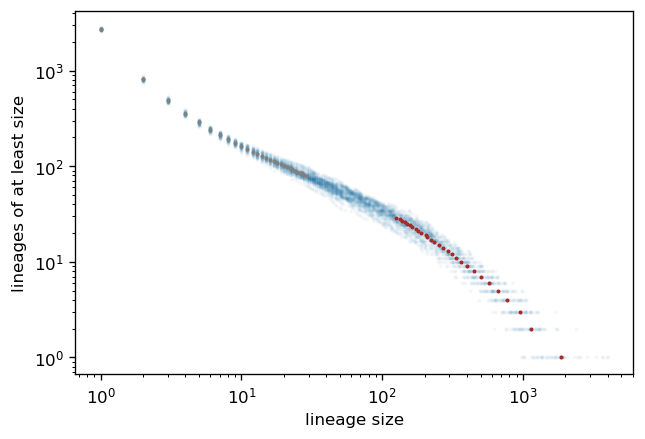

In [9]:
external_lineages_rate=300
exec_SIR(r0_0,I0,τ,vs0,vb0,
         nlp=θ,elr=external_lineages_rate,ps=150000, tp=test_prob,exec_type=0)
resL,_=tests_from_file()
draw_lineages_distr(freq_from_tests,resL)

Isn't that much better? And note S-like curving of the graphic, though much bigger than in real case above. 

Аlong with the tests.txt file, the procedure creates the dynamics.txt file. We can use it to check is the dynamics the same as HCS_SIR2: 

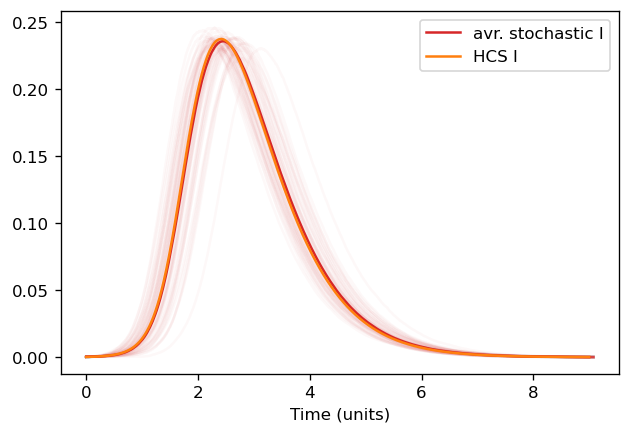

In [10]:
exec_SIR(r0_0,I0,τ,vs0,vb0,exec_type=0)
T,S,I=dynamics_from_file(I0,l_m=2000);
fig, ax = plt.subplots(dpi=120)
for t,i in zip(T,I):
    plt.plot(t, i,color='C3', alpha=0.03)
t,s,i=get_avr_trace(m_t,S,I)
plt.plot(t, i,color='C3', label=f'avr. stochastic I')    
s,i=HCS_SIR2(r0_0,I0,τ,vs0,vb0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
ax.set_xlabel(f'Time (units)')
plt.show()

Last, we check SIRS dynamics. It controlled by additional parameter s_rate. The parameter is the inverse of average time for recovered person to become susceptible again. Guessing the time around one year we use 0.04 as the parameter value.

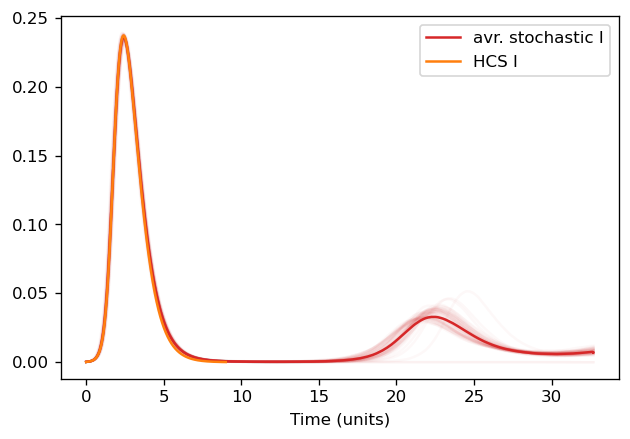

In [11]:
ft=35.0
exec_SIR(r0_0,I0,τ,vs0,vb0,T=ft,ps=1000000,s_rate=0.04,exec_type=3)
T,S,I=dynamics_from_file(I0);
fig, ax = plt.subplots(dpi=120)
for t,i in zip(T,I):
    plt.plot(t, i,color='C3', alpha=0.03)
t,s,i=get_avr_trace(np.arange(0.0,ft, t_step,dtype=np.float64),S,I)
plt.plot(t, i,color='C3', label=f'avr. stochastic I')    
s,i=HCS_SIR2(r0_0,I0,τ,vs0,vb0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
ax.set_xlabel(f'Time (units)')
plt.show()